## Ian Chow

## CTA200 Project

### 1.2 Theory

Finish this

## 2 Conservative Dynamics

### 2.1 Semi-analytic Equations of Motion

Import `rebound` and `celmech` packages as well as other libraries used:

In [1]:
import rebound as rb
import celmech as cm
import scipy
import numpy as np
import matplotlib.pyplot as plt
import radvel
import pandas as pd
import reboundx

# make font bigger
plt.rc('font', size=16)

Import data:

In [2]:
hd_data = pd.read_csv('hd45364_rvs.csv', sep =';')
hd_data.BJD -= 2.4e6

Params:

In [3]:
#Least squares fit: 
fit_params = [ 2.28513053e+02, 7.27743508e+00, 5.39371890e+04, -1.78110513e-01, 
              -4.66450116e-02, 3.43378023e+02, 1.78603199e+01, 5.40186750e+04,
               1.32165040e-01, 9.73129308e-02, -5.29039776e-01] 

# star mass, g and auday to m/s conversion factor
STAR_MASS = 920  # 920 jupiter masses
G = 2.825e-7  # converting G to jupiter masses, au, and days
AUDAY_MS = 1.731e6  # conversion factor for au/day to m/s

Get sim using least squares params:

In [4]:
def mass_to_semiamp(planet_mass, star_mass, period, eccentricity, inclination):
    """
    planet mass (jupiter masses) to semi amplitude
    """
    return ((2 * np.pi * G/period) ** (1/3) * (planet_mass * np.sin(inclination) / star_mass ** (2/3)) * (1/np.sqrt(1 - eccentricity ** 2)))

def semiamp_to_mass(semiamp, star_mass, period, eccentricity, inclination):
    """
    semi amplitude to planet mass (jupiter masses)
    """
    return (((2 * np.pi * G/period) ** (-1/3)) * (semiamp / np.sin(inclination)) * np.sqrt(1 - eccentricity ** 2) * (star_mass ** (2/3)))


def get_sim_from_params(params, inclination, integrator, time_base, star_mass = STAR_MASS, auday_ms = AUDAY_MS):
    """
    takes in params array, returns a rebound Simulation object with those parameters
    
    param params: numpy array of params:
    
    for i in range(0, num_planets):
    
    params[i + 0] is period
    params[i + 1] is semiamp
    params[i + 2] is tc (time of conjunction)
    params[i + 3] is sqrt(e) * cos(omega)
    params[i + 4] is sqrt(e) * sin(omega)
    
    params[5 * num_planets] is rv offset
    params[5 * num_planets + 1] is jit
    
    param inclination: inclination of system in the observation plane (pi/2 is in the plane of the sky, 0 is edge-on)
    param integrator: integrator to use, one of 'whfast' or 'ias15'
    param time_base: base time (to begin integration from) in the simulation
    """
    
    num_planets = int((len(params) - 1) / 5) # -2 because there are rv_offset and jit parameters:
    
    sim = rb.Simulation()
    sim.integrator = integrator
    sim.t = time_base  # keplerian and n-body models initialized at the same time offset
    # print(sim.t)
    if integrator == 'whfast':  # if using whfast integrator, set timestep
        sim.dt = 1/50 * min(params[0::5][:-1])  # timestep is 1/20th of the shortest orbital period of any planet
        # print(sim.dt)
    sim.units = ('AU', 'Mjupiter', 'day')

    sim.add(m = star_mass)  # star mass as a constant
        
    for i in range (0, num_planets):
        # print(i)
        # planet parameters
        period = params[5*i]  # in days
        semiamp = params[5*i + 1] / auday_ms # divide by auday_ms because semiamp given in m/s
        eccentricity = params[5*i + 3] ** 2 + params[5*i + 4] ** 2  # eccentricity from secos, sesin
        omega = np.arctan2(params[5*i + 3], params[5*i + 4])  # omega from arctan of sesin, secos
        # get tp by converting from tc
        tp = radvel.orbit.timetrans_to_timeperi(params[5*i + 2], per = period, ecc = eccentricity, omega = omega)
        
        # mass
        mass = semiamp_to_mass(semiamp = semiamp, star_mass = star_mass, period = period, eccentricity = eccentricity, inclination = inclination)
        
        # adding to simulation
        sim.add(m = mass, P = period, e = eccentricity, T = tp, omega = omega, inc = inclination)
        
    sim.move_to_com()  # move to center of mass
    
    return sim


Create sim from params:

In [5]:
time_base = np.median(hd_data.BJD)
sim = get_sim_from_params(fit_params, inclination = np.pi/2, integrator = 'ias15', time_base = 0)
cm.nbody_simulation_utilities.align_simulation(sim)

Construct Hamiltonian for the system:

In [6]:
pvars = cm.Poincare.from_Simulation(sim)
pham = cm.PoincareHamiltonian(pvars)
pham.H

   2   2   3    2   2   3
  G ⋅M₂ ⋅μ₂    G ⋅M₁ ⋅μ₁ 
- ────────── - ──────────
        2            2   
    2⋅Λ₂         2⋅Λ₁    

Now add eccentricity MMR terms (no inclination):

In [7]:
pham.add_MMR_terms(3, 1, max_order=3, inclinations=False)
pham.H

                                                                              
                                                                              
                                                                              
                                                               ⎛η₁⋅sin(2⋅λ₁ - 
  C_{(3,-2,-1,0,0,0)}_{1,2})__{(0,0,0,0),(0,0)}(\alpha⋅G⋅m₁⋅m₂⋅⎜──────────────
                                                               ⎜   ___________
                                                               ⎝ ╲╱ \Lambda_{1
- ────────────────────────────────────────────────────────────────────────────
                                                  a_{2,0}                     
                                                                              

                                                                              
                                                                              
                                                   

Now we want to compare $\theta_1$, $\theta_2$, $e_1$, $e_2$ and $P_2/P_1$ so we integrate over a series of times starting at $0$:

In [8]:
# inner and outer particles for rebound versus celmech

inner_rb = sim.particles[1]
outer_rb = sim.particles[2]

# defining times
Nout = 1000  # 1000 values
times = np.linspace(0, 0 + 300, Nout) * inner_rb.P  # 300 times the orbital period of teh inner planet
# defining parameters of interest
l1_rb, l2_rb, pomega1_rb, pomega2_rb, e1_rb, e2_rb, p1_rb, p2_rb = np.zeros(Nout), np.zeros(Nout), np.zeros(Nout), np.zeros(Nout), np.zeros(Nout), np.zeros(Nout), np.zeros(Nout), np.zeros(Nout)
l1_cm, l2_cm, pomega1_cm, pomega2_cm, e1_cm, e2_cm, p1_cm, p2_cm = np.zeros(Nout), np.zeros(Nout), np.zeros(Nout), np.zeros(Nout), np.zeros(Nout), np.zeros(Nout), np.zeros(Nout), np.zeros(Nout) 

Performing the integration and recording all the paramters required:

In [9]:
for i,t in enumerate(times):
    sim.integrate(t) # advance N-body
    pham.integrate(t) # advance celmech
    # inner, outer planets
    inner_cm = pvars.particles[1]
    outer_cm = pvars.particles[2]
    # mean longitude angles
    l1_rb[i] = inner_rb.l
    l2_rb[i] = outer_rb.l
    l1_cm[i] = inner_cm.l
    l2_cm[i] = outer_cm.l
    # pomegas
    pomega1_rb[i] = inner_rb.pomega
    pomega2_rb[i] = outer_rb.pomega
    pomega1_cm[i] = inner_cm.pomega
    pomega2_cm[i] = outer_cm.pomega
    # eccentricities
    e1_rb[i] = inner_rb.e
    e2_rb[i] = outer_rb.e
    e1_cm[i] = inner_cm.e
    e2_cm[i] = outer_cm.e
    # periods
    p1_rb[i] = inner_rb.P
    p2_rb[i] = outer_rb.P
    p1_cm[i] = inner_cm.P
    p2_cm[i]= outer_cm.P

Compute period ratio and resonant angles $\theta_i$:

In [10]:
# period ratio
pr_rb, pr_cm = p2_rb/p1_rb, p2_cm/p1_cm
# resonant angles
theta1_rb, theta1_cm = np.mod(3 * l2_rb - 2 * l1_rb - pomega1_rb, 2 * np.pi), np.mod(3 * l2_cm - 2 * l1_cm - pomega1_cm, 2 * np.pi)
theta2_rb, theta2_cm = np.mod(3 * l2_rb - 2 * l1_rb - pomega2_rb, 2 * np.pi), np.mod(3 * l2_cm - 2 * l1_cm - pomega2_cm, 2 * np.pi)

Plotting:

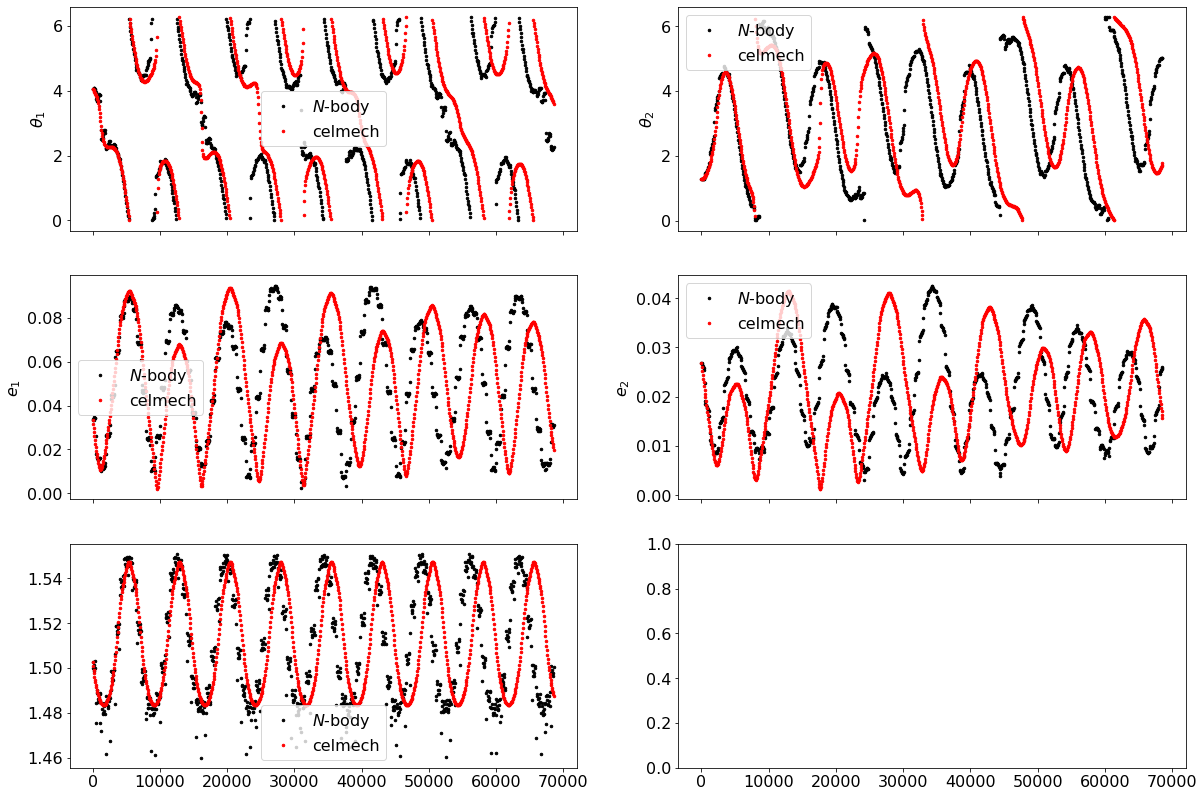

In [11]:
# Plotting:
fig, ((ax_theta1, ax_theta2), (ax_e1, ax_e2), (ax_pr, _ )) = plt.subplots(3, 2, sharex=True, figsize = (20, 14))
# theta1
ax_theta1.plot(times, theta1_rb, 'k.', label = r'$N$-body')
ax_theta1.plot(times, theta1_cm, 'r.', label = r'celmech')
ax_theta1.legend()
ax_theta1.set_ylabel(r'$\theta_1$')
# theta2
ax_theta2.plot(times, theta2_rb, 'k.', label = r'$N$-body')
ax_theta2.plot(times, theta2_cm, 'r.', label = r'celmech')
ax_theta2.legend()
ax_theta2.set_ylabel(r'$\theta_2$')
# e1
ax_e1.plot(times, e1_rb, 'k.', label = r'$N$-body')
ax_e1.plot(times, e1_cm, 'r.', label = r'celmech')
ax_e1.legend()
ax_e1.set_ylabel(r'$e_1$')
# e2
ax_e2.plot(times, e2_rb, 'k.', label = r'$N$-body')
ax_e2.plot(times, e2_cm, 'r.', label = r'celmech')
ax_e2.legend()
ax_e2.set_ylabel(r'$e_2$')
# period ratio
ax_pr.plot(times, pr_rb, 'k.', label = r'$N$-body')
ax_pr.plot(times, pr_cm, 'r.', label = r'celmech')
ax_pr.legend()

## 2.2 A simpler model through canonical transformations

## 2.2.1

We have canonical conjugate variables $(q_i, p_i)$ and we want to show that $Q_i = \sum_j A_{ij} q_j$ and $P_i = \sum_j \left(A^{-1}\right)_{ij}p_j$ are a canonical pair as well if $A$ is invertible:

We can do this by showing that $J = \mathcal{J}^T J \mathcal{J}$, where $J$ is the block matrix $J = \begin{bmatrix} 0 & I \\ -I & 0  \end{bmatrix}$, and $\mathcal{J}$ is the Jacobian of the transformation.

Computing the Jacobian $\mathcal{J}$, we have: $\frac{dQ}{dq} = \sum_j A_{ij}$, $\frac{dQ}{dp} = \frac{dP}{dq} = 0$, $\frac{dP}{dp} = \sum_j \left(A^{-1}\right)_{ij}$, so:

\begin{equation}
    \mathcal{J} = \begin{bmatrix} \sum_j A_{ij} & 0 \\ 0 & \sum_j A^{-1}_{ij} \end{bmatrix} \nonumber
\end{equation}
Which gives us:

\begin{align}
    \mathcal{J}^T J \mathcal{J} &= \begin{bmatrix} \sum_j A_{ij} & 0 \\ 0 & \sum_j A^{-1}_{ij} \end{bmatrix} \begin{bmatrix} 0 & I \\ -I & 0  \end{bmatrix} \begin{bmatrix} \sum_j A_{ij} & 0 \\ 0 & \sum_j A^{-1}_{ij} \end{bmatrix} \\
    \mathcal{J}^T J \mathcal{J} &= \begin{bmatrix} \sum_j A_{ij} & 0 \\ 0 & \sum_j A^{-1}_{ij} \end{bmatrix} \begin{bmatrix} 0 & \sum_j A_{ij} \\ -\sum_j A^{-1}_{ij} & 0 \end{bmatrix} \\
    \mathcal{J}^T J \mathcal{J} &= \begin{bmatrix} 0 & \sum_j A_{ij} \sum_j A^{-1}_{ij} \\ -\sum_j A^{-1}_{ij} \sum_j A_{ij} & 0 \end{bmatrix} \\
    \mathcal{J}^T J \mathcal{J} &= \begin{bmatrix} 0 & I \\ -I & 0  \end{bmatrix} & \text{$AA^{-1} = A^{-1}A = I$} \\
    \mathcal{J}^T J \mathcal{J} &= J \nonumber
\end{align}

and therefore $Q_i$, $P_i$ are a canonical pair.

## 2.2.2

We now want to show that if $(q, p)$ are a pair of canonical variables, then $y = \sqrt{2p}\sin{q}$, $x = \sqrt{2p}\cos{q}$ are a pair of canonical variables as well. We will do so in the same way as in $2.2.1$ (showing that $J = \mathcal{J}^T J \mathcal{J}$):

Computing the Jacobian $\mathcal{J}$, we have: $\frac{dy}{dq} = \sqrt{2p}\cos{q}$, $\frac{dy}{dp} = \frac{\sin{q}}{\sqrt{2p}}$, $\frac{dx}{dq} = -\sqrt{2p}\sin{q}$, $\frac{dx}{dp} = \frac{\cos{q}}{\sqrt{2p}}$, so:

\begin{equation}
    \mathcal{J} = \begin{bmatrix} \sqrt{2p}\cos{q} & \frac{\sin{q}}{\sqrt{2p}} \\ -\sqrt{2p}\sin{q} & \frac{\cos{q}}{\sqrt{2p}} \end{bmatrix} \nonumber
\end{equation}
Then we have:
\begin{align}
    \mathcal{J}^T J \mathcal{J} &= \begin{bmatrix} \sqrt{2p}\cos{q} & -\sqrt{2p}\sin{q} \\ \frac{\sin{q}}{\sqrt{2p}} & \frac{\cos{q}}{\sqrt{2p}} \end{bmatrix} \begin{bmatrix} 0 & I \\ -I & 0  \end{bmatrix} \begin{bmatrix} \sqrt{2p}\cos{q} & \frac{\sin{q}}{\sqrt{2p}} \\ -\sqrt{2p}\sin{q} & \frac{\cos{q}}{\sqrt{2p}} \end{bmatrix}  \\
    \mathcal{J}^T J \mathcal{J} &= \begin{bmatrix} \sqrt{2p}\cos{q} & -\sqrt{2p}\sin{q} \\ \frac{\sin{q}}{\sqrt{2p}} & \frac{\cos{q}}{\sqrt{2p}} \end{bmatrix} \begin{bmatrix} -\sqrt{2p}\sin{q} & \frac{\cos{q}}{\sqrt{2p}} \\ -\sqrt{2p}\cos{q} & -\frac{\sin{q}}{\sqrt{2p}} \end{bmatrix} \\
    \mathcal{J}^T J \mathcal{J} &= \begin{bmatrix} -2p \sin{q}\cos{q} + 2p \sin{q}\cos{q} & \cos^2{q} + \sin^2{q} \\ -\sin^2{q} - \cos^2{q} & \frac{\sin{q} \cos{q}}{2p} - \frac{\sin{q}\cos{q}}{2p} \end{bmatrix} \\
    \mathcal{J}^T J \mathcal{J} &= \begin{bmatrix} 0 & 1 \\ -1 & 0  \end{bmatrix} & \text{$\cos^2{q} + \sin^2{q} = 1$} \\
    \mathcal{J}^T J \mathcal{J} &= J \nonumber
\end{align}

and therefore $y, x$ are a canonical pair.

### 2.2.3

Re-create the simulation, this time using only $1$st order MMR terms (still no inclination):

In [12]:
# time_base = np.median(hd_data.BJD)

# make simulation
sim = get_sim_from_params(fit_params, inclination = np.pi/2, integrator = 'ias15', time_base = 0)
cm.nbody_simulation_utilities.align_simulation(sim)
# convert to poincarehamiltonian
pvars = cm.Poincare.from_Simulation(sim)
pham = cm.PoincareHamiltonian(pvars)
pham.add_MMR_terms(3, 1, max_order=1, inclinations=False)
pham.H

                                                               ⎛η₁⋅sin(2⋅λ₁ - 
  C_{(3,-2,-1,0,0,0)}_{1,2})__{(0,0,0,0),(0,0)}(\alpha⋅G⋅m₁⋅m₂⋅⎜──────────────
                                                               ⎜   ___________
                                                               ⎝ ╲╱ \Lambda_{1
- ────────────────────────────────────────────────────────────────────────────
                                                  a_{2,0}                     
                                                                              

3⋅λ₂)   κ₁⋅cos(2⋅λ₁ - 3⋅λ₂)⎞                                                  
───── + ───────────────────⎟   C_{(3,-2,0,-1,0,0)}_{1,2})__{(0,0,0,0),(0,0)}(\
____       _______________ ⎟                                                  
,0}      ╲╱ \Lambda_{1,0}  ⎠                                                  
──────────────────────────── - ───────────────────────────────────────────────
                                                   

Create canonical transformation from poincare angles matrix:

In [13]:
import sympy as sp
# defining stuff:

# action variables
# Lambda1, Lambda2, Gamma1, Gamma2, Q1, Q2 = sp.symbols('Lambda_1, Lambda_2, Gamma_1, Gamma_2, Q_1, Q_2')
# old angle coordinates
lambda1, lambda2, pomega1, pomega2, Omega1, Omega2 = sp.symbols('lambda_1, lambda_2, varpi_1, varpi_2, Omega_1, Omega_2')
# new angle coordinates
theta1, theta2, l, psi, phi1, phi2 = sp.symbols('theta_1, theta_2, l, psi, phi_1, phi_2')
p1, p2, L, Psi, Phi1, Phi2 = sp.symbols('p_1, p_2, L, Psi, Phi_1, Phi_2')

# converts
# lambda_1, lambda_2, pomega_1, pomega_2, Omega_1, Omega_2 to
# theta_1, theta_2, l, psi, phi_1, phi_2
pmatrix = [[-2, 3, 1, 0, 0, 0], [-2, 3, 0, 1, 0, 0], [-2, 3, 0, 0, 0, 0], 
           [1, -1, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 0, 1]]

ct = cm.CanonicalTransformation.from_poincare_angles_matrix(pvars, pmatrix, 
                                                            new_qp_pairs = [(theta1, p1), (theta2, p2), 
                                                                            (l, L), (psi, Psi), 
                                                                            (phi1, Phi1), (phi2, Phi2)])
ct.old_qp_vars, ct.new_qp_vars

([λ₁, η₁, ρ₁, λ₂, η₂, ρ₂, Λ₁, κ₁, σ₁, Λ₂, κ₂, σ₂], [θ₁, θ₂, l, ψ, φ₁, φ₂, p₁, 
p₂, L, Ψ, Φ₁, Φ₂])

Create new Hamiltonian:

In [14]:
new_ham = ct.old_to_new_hamiltonian(pham, do_reduction=True)
new_ham.H

                                                                    ____      
  √2⋅C_{(3,-2,-1,0,0,0)}_{1,2})__{(0,0,0,0),(0,0)}(\alpha⋅G⋅m₁⋅m₂⋅╲╱ p₁ ⋅cos(θ
- ────────────────────────────────────────────────────────────────────────────
                              _______________                                 
                            ╲╱ \Lambda_{1,0} ⋅a_{2,0}                         

                                                                       ____   
₁)   √2⋅C_{(3,-2,0,-1,0,0)}_{1,2})__{(0,0,0,0),(0,0)}(\alpha⋅G⋅m₁⋅m₂⋅╲╱ p₂ ⋅co
── - ─────────────────────────────────────────────────────────────────────────
                                 _______________                              
                               ╲╱ \Lambda_{2,0} ⋅a_{2,0}                      

                  2   2   3                    2   2   3        
s(θ₂)            G ⋅M₁ ⋅μ₁                    G ⋅M₂ ⋅μ₂         
───── - ─────────────────────────── - ──────────────────────────
             

### 2.2.4

Use root-finding method (multivariate Newton's method in this case) to solve for $\dot\theta_i = \dot p_i = 0$. Check the flow and Jacobian of the Hamilotnian given the current values for the qp pairs:

In [15]:
vals = new_ham.values
new_ham.flow_func(*vals).T, new_ham.jacobian_func(*vals)  # transpose flow so it's a row vector

(array([[-5.55439389e-04, -1.92352891e-04, -1.87959981e-09,
         -2.21760762e-09]]),
 array([[ 6.12768695e-04,  0.00000000e+00, -2.70932554e+01,
         -1.78440090e+02],
        [ 0.00000000e+00,  3.53966442e-04, -1.78440090e+02,
         -1.62294404e+02],
        [-1.42400327e-09,  0.00000000e+00, -6.12768695e-04,
          0.00000000e+00],
        [ 0.00000000e+00, -6.33726306e-10,  0.00000000e+00,
         -3.53966442e-04]]))

Coordinate transform $(p, \theta) \to (x, y)$ so Newton's method works:

In [16]:
ctxy = cm.CanonicalTransformation.polar_to_cartesian(new_ham.full_qp_vars,[0,1])
hamxy = ctxy.old_to_new_hamiltonian(new_ham)

Solve for the root using Newton's method:

In [17]:
from scipy.linalg import solve as lin_solve 

y = hamxy.values
fun = lambda x: hamxy.flow_func(*x).reshape(-1)
dfun = lambda x: hamxy.jacobian_func(*x)

# newton's method
def newton_solve(fun,Dfun,guess,max_iter=100,rtol=1e-6,atol=1e-12):
    y = guess.copy()
    for itr in range(max_iter):
        f = fun(y)
        Df = Dfun(y)
        dy = -1 * lin_solve(Df,f)
        y+=dy
        if np.alltrue( np.abs(dy) < rtol * np.abs(y) + atol ):
            break
    else:
        print("did not converge")
    return y

# solve 
solution = newton_solve(fun, dfun, y)

Compare Newton's method solution to the original values to check that it does result in $\dot x_i = \dot y_i \approx 0$ as required:

In [18]:
fun(y), fun(solution)  # solution is pretty close to 0

(array([ 1.44287208e-06, -9.84168503e-07, -1.27315052e-07,  2.19487059e-07]),
 array([-1.63053842e-20, -2.22346149e-21,  2.42188291e-38,  1.26476108e-37]))

Put these values back into the Hamiltonian, and then convert from $(x, y)$ back to $(p, \theta)$:

In [19]:
hamxy.state.values = solution  # put these values back into the Hamiltonian
# convert all the values of Hamiltonian in the xy coordinates back to theta p coordinates
theta_p_full_values = ctxy.new_to_old_array(hamxy.full_values)
# then put the theta and p values back into the theta p hamiltonian
theta_p_values = np.concatenate((theta_p_full_values[0:2], theta_p_full_values[6:8]))
new_ham.state.values = theta_p_values

And showing that $\dot\theta_i = \dot p_i \approx 0$ in the $(\theta, p)$ coordinates as well by comparing the flow function evaluated at the new values compared to the old ones:

In [20]:
new_ham.flow_func(*vals).T, new_ham.flow_func(*new_ham.values).T  # new values much closer to 0

(array([[-5.55439389e-04, -1.92352891e-04, -1.87959981e-09,
         -2.21760762e-09]]),
 array([[ 1.46475714e-16,  1.53523028e-16,  7.29310702e-41,
         -2.32557395e-25]]))

So the values of $p_1, p_2, \theta_1, \theta_2$ are thus: 

In [21]:
new_ham.values, new_ham.qp_vars

([1.798761455752695e-32, 3.141592653589793, 4.534077009398353e-06, 2.123582709
9578995e-06], [θ₁, θ₂, p₁, p₂])

### 2.2.5

Now turn the Hamiltonian we found at the equilibrium value into a `rebound` simulation. First convert from $(p, \theta)$ back to the default $\eta, \kappa$ variables used by `PoincareHamiltonian` to convert to a `rebound` simulation:

In [22]:
# convert from p, theta back to the default poincare variables
pvars.values = ct.new_to_old_array(new_ham.full_values)
# convert to a rebound simulation
sim_eq = cm.Poincare.to_Simulation(pvars)
inner = sim_eq.particles[1]
outer = sim_eq.particles[2]

Now, compute the time evolution of $\theta_i(t)$ in the `rebound` simulation:

In [23]:
t_end = 3e3
ntimes = 5000

# create times array and empty array to track the resonance angles theta
times_eq = np.linspace(sim_eq.t, sim_eq.t + t_end, ntimes) * inner.P  # 3e3 times the orbital period of the inner planet
theta1_eq, theta2_eq = np.zeros(ntimes), np.zeros(ntimes)

# integrate over times and record theta_1, theta_2
for i,t in enumerate(times_eq):
    sim_eq.integrate(t)  # advance simulation
    # record theta1, theta2
    theta1_eq[i] = np.mod(3 * outer.l - 2 * inner.l - inner.pomega, 2 * np.pi)
    theta2_eq[i] = np.mod(3 * outer.l - 2 * inner.l - outer.pomega, 2 * np.pi)

And plot our results:

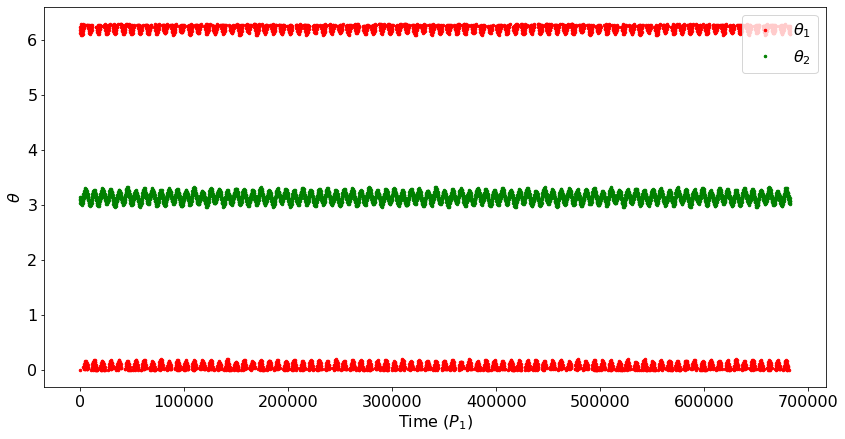

In [24]:
plt.figure(figsize = (14, 7))
plt.plot(times_eq, theta1_eq, 'r.', label = r'$\theta_1$')
plt.plot(times_eq, theta2_eq, 'g.', label = r'$\theta_2$')
plt.xlabel(r'Time $(P_1)$'), plt.ylabel(r'$\theta$')
plt.legend()
plt.show()

The graph visually appears quite close to the actual equilibrium value (taking $\theta \mod 2 \pi$) for $\theta_i$), as expected.

## 3 Dissipative dynamics

## 3.1

Deriving the equations for $\frac{d\Lambda_i}{dt}$, $\frac{d\eta_i}{dt}$, and $\frac{d\kappa_i}{dt}$ under the effects of dissipative forces given by:

\begin{align}
    \frac{d\ln{e_i}}{dt} = -\frac{1}{\tau_{e,i}} \nonumber \\
    \frac{d\ln{a_i}}{dt} = -\frac{1}{\tau_{a, i}} \nonumber
\end{align}

and the $\tau_{e, i}$ expression can be rearranged to (using the chain rule)

\begin{align}
    \frac{1}{e_i} \frac{d e_i}{dt} &= -\frac{1}{\tau_{e,i}} \nonumber \\
    \frac{d e_i}{dt} &= -\frac{e_i}{\tau_{e, i}} \nonumber
\end{align}

and similarly with $\tau_{a, i}$.

Now start with the equation for $\Lambda$:
\begin{equation}
    \Lambda_i = \mu_i \sqrt{G\left(M_\star + m_i\right) a_i} \nonumber
\end{equation}

Differentiate it to get:

\begin{align}
    \frac{d}{dt}\Lambda_i &= \frac{\mu_i \sqrt{G\left(M_\star + m_i\right)}}{2\sqrt{a_i}} \frac{da_i}{dt} & \text{chain rule since $a_i = a_i(t)$} \nonumber \\
    \frac{d}{dt}\Lambda_i &= \frac{\mu_i \sqrt{G\left(M_\star + m_i\right)}}{2\sqrt{a_i}}\,\frac{-a_i}{\tau_{a, i}} \nonumber & \text{since  $\frac{da_i}{dt} = -\frac{a_i}{\tau_{a, i}}$} \\
    \frac{d}{dt}\Lambda_i &= -\frac{\mu_i \sqrt{G\left(M_\star + m_i\right) a_i}}{2\tau_{a,i}} \\
    \frac{d}{dt}\Lambda_i &= -\frac{\Lambda_i}{2 \tau_{a, i}} \nonumber
\end{align}
So $\dot\Lambda_i = -\frac{\Lambda_i}{2 \tau_{a, i}}$.

Now since $\eta = \sqrt{2 \Gamma} \sin{\gamma}$ and $\kappa = \sqrt{2 \Gamma}\cos{\gamma}$, we have, substituting $\Gamma$ into $\eta$:

\begin{equation}
    \eta = \sqrt{2 \mu_i \sqrt{G\left(M_\star + m_i\right)a_i} \left(1 - \sqrt{1 - e_i^2}\right)}\sin{\gamma}
\end{equation}

Then using a Taylor approximation for $\sqrt{1 - e_i^2} \approx 1 - \frac{e_i^2}{2} + \mathcal{O\left(e_i\right)}^4$:
\begin{align}
    \eta &= \sqrt{2 \mu_i \sqrt{G\left(M_\star + m_i\right)a_i} \left(\frac{e_i^2}{2}\right)}\sin{\gamma} \nonumber \\
    \eta &= \sqrt{\Lambda_i}\ \ e_i \sin{\gamma} & \text{substituting $\Lambda_i$ from earlier} \nonumber
\end{align}

We then differentiate, using the chain and product rule to get:

\begin{align}
    \frac{d\eta}{dt} &= \sqrt{\Lambda_i}\sin\gamma \frac{de_i}{dt} + \frac{e_i}{2\sqrt{\Lambda_i}}\, \cdot \frac{d\Lambda_i}{dt} \sin\gamma \nonumber & \text{since $\dot \gamma = 0$ that term disappears}  \\
    \frac{d\eta}{dt} &= \sqrt{\Lambda_i}\sin\gamma \cdot -\frac{e_i}{\tau_{e, i}} + \frac{e_i}{2\sqrt{\Lambda_i}}\, \cdot \frac{-\Lambda_i}{2\tau_{a, i}} \sin\gamma \nonumber  & \text{using $\frac{de_i}{dt} = -\frac{e_i}{\tau_{e, i}}$ and $\frac{d\Lambda_i}{dt} = -\frac{\Lambda_i}{2\tau_{a, i}}$} \\
    \frac{d\eta}{dt} &= -\sqrt{\Lambda_i}\ \ e_i \sin\gamma \left(\frac{1}{\tau_{e, i}} + \frac{1}{4 \tau_{a, i}}\right) \nonumber \\
    \frac{d\eta}{dt} &= -\eta \left(\frac{1}{\tau_{e, i}} + \frac{1}{4 \tau_{a, i}}\right) \nonumber
\end{align}

So $\dot\eta = -\eta \left(\frac{1}{\tau_{e, i}} + \frac{1}{4 \tau_{a, i}}\right)$.

Finally, since $\gamma$ is a free parameter in the above calculation ($\dot \gamma = 0$) we can use the same method to obtain an expression for $\frac{d\kappa}{dt}$ as $\dot\kappa = -\kappa \left(\frac{1}{\tau_{e, i}} + \frac{1}{4 \tau_{a, i}}\right)$.

## 3.2

Create a new Keplerian Hamiltonian using the equilibrium values from before, adding the interaction terms to first order:

In [25]:
pham_eq = cm.PoincareHamiltonian(pvars)
pham_eq.add_MMR_terms(3, 1, max_order=1, inclinations=False)

Define the equations for $\frac{d\Lambda_i}{dt}$, $\frac{d\eta_i}{dt}$, and $\frac{d\kappa_i}{dt}$ as determined in section 3.1:

In [26]:
# symbols

tau_a_1, tau_e_1 = sp.symbols('tau_a_1, tau_e_1')
tau_a_2, tau_e_2 = sp.symbols('tau_a_2, tau_e_2')
Lambda1 = pham_eq.qp_vars[6]
Lambda2 = pham_eq.qp_vars[9]
eta_1 = pham_eq.qp_vars[1]
eta_2 = pham_eq.qp_vars[4]
kappa_1 = pham_eq.qp_vars[7]
kappa_2 = pham_eq.qp_vars[10]
t = sp.symbols('t')

# dLambda, deta, dkappa equations:

dLambda_1 = -Lambda1/(2 * tau_a_1)
dLambda_2 = -Lambda2/(2 * tau_a_2)

deta_1 = -eta_1 * (1/(4 * tau_a_1) + 1/tau_e_1)
deta_2 = -eta_2 * (1/(4 * tau_a_2) + 1/tau_e_2)

dkappa_1 = -kappa_1 * (1/(4 * tau_a_1) + 1/tau_e_1)
dkappa_2 = -kappa_2 * (1/(4 * tau_a_2) + 1/tau_e_2)

dLambda_1, deta_1, dkappa_1

⎛ -Λ₁        ⎛ 1       1   ⎞      ⎛ 1       1   ⎞⎞
⎜──────, -η₁⋅⎜──── + ──────⎟, -κ₁⋅⎜──── + ──────⎟⎟
⎝2⋅τₐ ₁      ⎝τₑ ₁   4⋅τₐ ₁⎠      ⎝τₑ ₁   4⋅τₐ ₁⎠⎠

Create a matrix for the dissipative terms:

In [27]:
dissipative = sp.zeros(len(pham_eq.values), 1)

# add lambda, eta, kappa dissipative terms
dissipative[6] = dLambda_1
dissipative[9] = dLambda_2

dissipative[1] = deta_1
dissipative[4] = deta_2

dissipative[7] = dkappa_1
dissipative[10] = dkappa_2

Turn the new Hamiltonian plus the dissipative terms into a function for the equations of motion including dissipative terms:

In [28]:
ham_eom = sp.lambdify([t, pham_eq.qp_vars, tau_a_1, tau_a_2, tau_e_1, tau_e_2], dissipative + pham_eq.N_flow)

Define the $\tau_{\alpha_i}$ and $\tau_{e_i}$ values required for the equations of motion:

In [29]:
def get_tau_alphas(tau_alpha, m_inner, m_outer, period_ratio):
    # use Kepler's third law to compute the ratio of semi-major axes in resonance from the period ratio in resonance
    sma_ratio = period_ratio ** (2/3)  # ratio of outer planet's semi-major axis to inner
    # define matrix A
    A = np.array([[-1, 1],
                 [m_outer, m_inner * sma_ratio]])
    # compute gamma_1 and gamma_2
    gammas = np.matmul(np.linalg.inv(A), np.array([-1/tau_alpha, 0]))
    # gamma = 1/tau
    taus = 1/gammas
    
    return tuple(taus)  # returns (tau_alpha_outer, tau_alpha_inner) as a tuple

tau_e_factor = 3
K_test = 10
resonant_period_ratio = 3/2

# use tau_e values of timescale/3

tau_e_1_val, tau_e_2_val = -times_eq[-1]/tau_e_factor, -times_eq[-1]/tau_e_factor
tau_e_val = 1 / (1 / tau_e_1_val + 1 / tau_e_2_val)

tau_a_val = tau_e_val * K_test  # use k value

# compute tau_a values
tau_a_2_val, tau_a_1_val = get_tau_alphas(tau_alpha = tau_a_val, m_inner=inner.m, m_outer = outer.m, period_ratio = resonant_period_ratio)
tau_a_1_val, tau_a_2_val, tau_e_1_val, tau_e_2_val

(1667848.3680556815, -3578649.5149611505, -227528.7205467862, -227528.72054678
62)

Use `scipy.integrate.solve_ivp()` with the `DOP853` method to numerically integrate the equations of motion:

In [30]:
from scipy.integrate import solve_ivp

y0 = pham_eq.values
# set to negative since reboundx has them as -tau timescales while our eom has them as positive
params = (-tau_a_1_val, -tau_a_2_val, -tau_e_1_val, -tau_e_2_val)  # these are the tau_a and tau_e_params as a tuple

# solving the ivp
sols = solve_ivp(lambda t,x: ham_eom(t,x,*params).reshape(-1), [times_eq[0], times_eq[-1]], y0 = y0, dense_output=True, method='DOP853')

In [31]:
sols.message, sols.y.shape

('The solver successfully reached the end of the integration interval.',
 (12, 200))

Create a simulation using `REBOUND` and `REBOUNDx` (using the earlier `sim_eq` simulation)

In [32]:
sim_eq = cm.Poincare.to_Simulation(pvars)
pvars2 = pvars.copy()  # copy for later

inner = sim_eq.particles[1]
outer = sim_eq.particles[2]
# reboundx
rebx = reboundx.Extras(sim_eq)
rebx.add_force(rebx.load_force('modify_orbits_forces'))
rebx.add_operator(rebx.load_operator('modify_orbits_direct'))

inner.params['tau_e'] = tau_e_1_val  # eccentricity damping, these stay constant
outer.params['tau_e'] = tau_e_2_val

inner.params['tau_a'], outer.params['tau_a'] = tau_a_1_val, tau_a_2_val

 Now compare `sim_eq` to the results obtained by numerically integrating over the equations of motion:

In [33]:
e_inner_eom = np.zeros(len(sols.y.T))
e_outer_eom = np.zeros(len(sols.y.T))
e_inner_rb, e_outer_rb = np.zeros(len(sols.y.T)), np.zeros(len(sols.y.T))

p_inner_eom, p_outer_eom = np.zeros(len(sols.y.T)), np.zeros(len(sols.y.T))
p_inner_rb, p_outer_rb = np.zeros(len(sols.y.T)), np.zeros(len(sols.y.T))

for i, val in enumerate(sols.y.T):
    pvars.values = val
    e_inner_eom[i] = pvars.particles[1].e
    e_outer_eom[i] = pvars.particles[2].e
    
    p_inner_eom[i] = pvars.particles[1].P
    p_outer_eom[i] = pvars.particles[2].P
    
from tqdm import tqdm    

for i, t in tqdm(enumerate(sols.t)):
    sim_eq.integrate(t)
    e_inner_rb[i] = inner.e
    e_outer_rb[i] = outer.e
    p_inner_rb[i] = inner.P
    p_outer_rb[i] = outer.P

200it [00:04, 47.50it/s]


And plot:

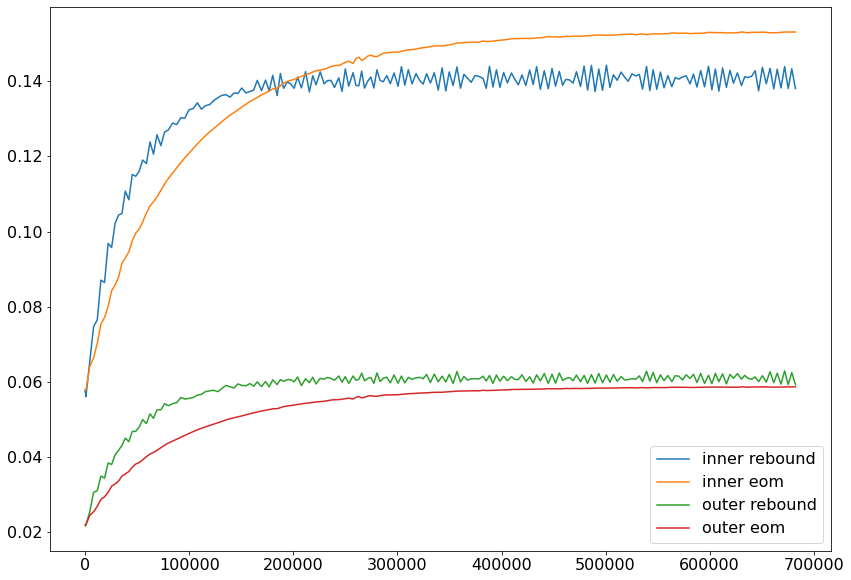

In [34]:
plt.figure(figsize = (14, 10))
plt.plot(sols.t, e_inner_rb, label = 'inner rebound')
plt.plot(sols.t, e_inner_eom, label = 'inner eom')
plt.plot(sols.t, e_outer_rb, label = 'outer rebound')
plt.plot(sols.t, e_outer_eom, label = 'outer eom')
plt.legend()


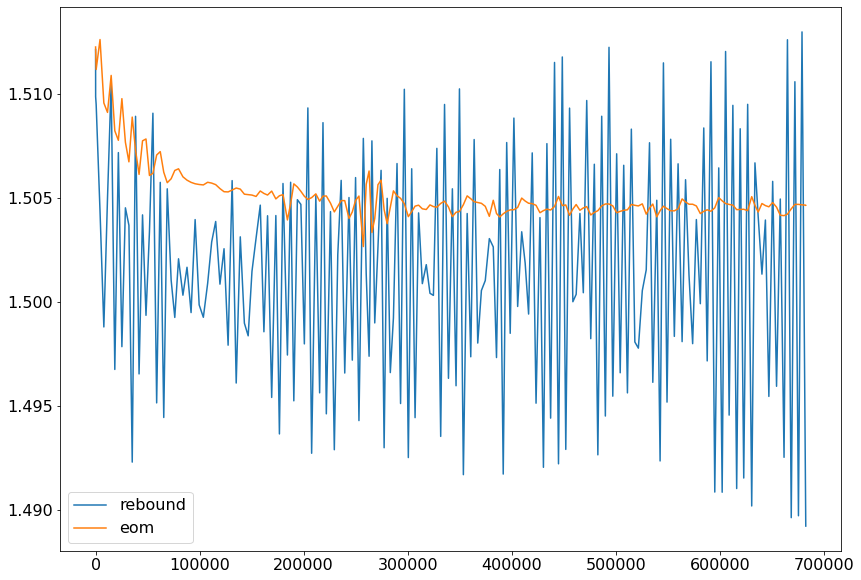

In [35]:
plt.figure(figsize = (14, 10))
plt.plot(sols.t, p_outer_rb/p_inner_rb, label = 'rebound')
plt.plot(sols.t, p_outer_eom/p_inner_eom, label = 'eom')
plt.legend()

## 3.3 

Add dissipative dynamics to the Hamiltonian from section $2.2$ (using $(p, \theta)$ and have $L$, $\Psi$ as explicit parameters in the flow:

In [36]:
# add L and Psi to the qp variables since we want those too
dyvars = new_ham.qp_vars  # qp variables
L = new_ham.full_qp_vars[-4]
Psi = new_ham.full_qp_vars[-3]
# add L and Psi to the qp variables
dyvars += [L,Psi]

# make a new flow matrix that's 1x6 and has l and Psi added to dyvars 
newflow = sp.Matrix(np.zeros(len(dyvars)))
# L and Psi are 0 since they are conserved
for i,val in enumerate(new_ham.N_flow):
    newflow[i] = val

newflow

⎡      1.34736023529189e-9                 1.36448095093558e-10         6.7320
⎢──────────────────────────────── - ───────────────────────────────── + ──────
⎢                               3                                   3         
⎢(p₁ + p₂ + 0.00290176891380818)    (-p₁ - p₂ + 0.00135865427738798)          
⎢                                                                             
⎢      1.34736023529189e-9                 1.36448095093558e-10         4.6072
⎢──────────────────────────────── - ───────────────────────────────── - ──────
⎢                               3                                   3         
⎢(p₁ + p₂ + 0.00290176891380818)    (-p₁ - p₂ + 0.00135865427738798)          
⎢                                                                             
⎢                                                        ____                 
⎢                                1.3464169490854e-6⋅√2⋅╲╱ p₁ ⋅sin(θ₁)         
⎢                                                   

Reinitialize the `rebound` simulation to get the `pvars` from:

In [37]:
def get_simple_sim(masses, integrator = 'ias15', period_ratio = 3/2, epsilon=0.01):
    """
    gets simple sim (for eccentricity track stuff)
    param masses: array of planet masses, normalized to fraction of the star's mass
    param integrator: integrator
    param epsilon: amount by which the resonant period ratio should be offset from the equilibrium in the simulation
    """
    sim = rb.Simulation()
    sim.integrator = integrator
    # central star
    sim.add(m = 1)
    
    sim.add(m = masses[0], P = 1)
    sim.add(m = masses[1], P = period_ratio * (1 + epsilon))

    sim.move_to_com()
    if integrator == 'whfast':
        sim.dt = 1/50 * 1  # dy default use 1/50th of the inner planet's orbital period for the timestep if using whfast
    return sim

In [38]:
# # best-fit params
# best_fit_sim = get_sim_from_params(fit_params, inclination = np.pi/2, integrator = 'ias15', time_base = 0)
# cm.nbody_simulation_utilities.align_simulation(sim)
# # inner, outer planet masses
# m1 = best_fit_sim.particles[1].m/best_fit_sim.particles[0].m  # normalized to fraction of the star's mass
# m2 = best_fit_sim.particles[2].m/best_fit_sim.particles[0].m
# # simple sim masses
# sim = get_simple_sim(masses = [m1, m2], integrator = 'ias15', period_ratio = resonant_period_ratio, epsilon = 0.01)
# # convert to poincarehamiltonian
sim = cm.Poincare.to_Simulation(pvars2)
# masses
m1 = sim.particles[1].m/sim.particles[0].m
m2 = sim.particles[2].m/sim.particles[0].m
# pvars
pvars = cm.Poincare.from_Simulation(sim)

To find the dissipative term in the flow we transform from $\Gamma$, $\eta$, $\kappa$ back to the 2.25 $p, \theta$ Hamiltonian and compute the Jacobian of the coordinate transform:

In [39]:
ct_jac = sp.Matrix([[sp.diff(ct.new_to_old(dyvar), var) for var in pham_eq.qp_vars] for dyvar in dyvars])
ct_jac

⎡        κ₁                               -η₁                       ⎤
⎢-2  ─────────  0  3      0      0  0  ─────────  0  0      0      0⎥
⎢      2     2                           2     2                    ⎥
⎢    η₁  + κ₁                          η₁  + κ₁                     ⎥
⎢                                                                   ⎥
⎢                         κ₂                               -η₂      ⎥
⎢-2      0      0  3  ─────────  0  0      0      0  0  ─────────  0⎥
⎢                       2     2                           2     2   ⎥
⎢                     η₂  + κ₂                          η₂  + κ₂    ⎥
⎢                                                                   ⎥
⎢0      η₁      0  0      0      0  0     κ₁      0  0      0      0⎥
⎢                                                                   ⎥
⎢0       0      0  0     η₂      0  0      0      0  0     κ₂      0⎥
⎢                                                                   ⎥
⎢0      -η₁     0  0

Then we transform the dissipative term computed in 2.2.5 to $p, \theta$ coordinates using the Jacobian, and add the flow term (with $L$, $\Psi$ as explicit variables):

In [40]:
f_prime = sp.simplify(sp.Matrix([ct.old_to_new(val) for val in ct_jac @ dissipative])) + newflow
f_prime

⎡                                       0                                     
⎢                                                                             
⎢                                       0                                     
⎢                                                                             
⎢                                  2⋅p₁     p₁                                
⎢                                - ──── - ──────                              
⎢                                  τₑ ₁   2⋅τₐ ₁                              
⎢                                                                             
⎢                                  2⋅p₂     p₂                                
⎢                                - ──── - ──────                              
⎢                                  τₑ ₂   2⋅τₐ ₂                              
⎢                                                                             
⎢   3⋅L      L       Ψ        Ψ      2⋅p₁    3⋅p₁   

Now we solve the ivp for the flow:

In [41]:
tau_e_factor = 3
K_test = 10  # use some K value
resonant_period_ratio = 3/2

# use tau_e values of timescale/3

tau_e_1_val, tau_e_2_val = -times_eq[-1]/tau_e_factor, -times_eq[-1]/tau_e_factor
tau_e_val = 1 / (1 / tau_e_1_val + 1 / tau_e_2_val)
tau_a_val = tau_e_val * K_test

# compute tau_a values
tau_a_2_val, tau_a_1_val = get_tau_alphas(tau_alpha = tau_a_val, m_inner = m1, m_outer = m2, period_ratio = resonant_period_ratio)

# tau_a_1 > 0, other 3 timescales < 0
tau_a_1_val, tau_a_2_val, tau_e_1_val, tau_e_2_val

(1667848.3680556815, -3578649.5149611505, -227528.7205467862, -227528.72054678
62)

In [42]:
from scipy.integrate import solve_ivp

# lambdify f prime to solve the hamiltonian eom
t = sp.symbols('t')
ham_eom_ptheta = sp.lambdify([t, dyvars, tau_a_1, tau_a_2, tau_e_1, tau_e_2], f_prime)

# starting conditions for the ivp y0 and timescales tau_a and tau_e
y0 = [new_ham.full_qp[v] for v in dyvars]
# y0[0] += 0.5  # move it slightly away from equilibrium

# set to negative since reboundx has them as -tau timescale wihle our equations of motion havepositive tau
params = (-tau_a_1_val, -tau_a_2_val, -tau_e_1_val, -tau_e_2_val)  # these are the tau_a and tau_e_params as a tuple

# solving the ivp
sols = solve_ivp(lambda t,x: ham_eom_ptheta(t,x,*params).reshape(-1), [times_eq[0], times_eq[-1]], y0 = y0, dense_output=True, method='DOP853',atol=1e-13)

In [43]:
sols.message, sols.y.shape

('The solver successfully reached the end of the integration interval.',
 (6, 10))

Grab values of $e$, $P$ from the `pvars` by solving the Hamiltonian, and compare to `rebound` simulation:

In [44]:
e_inner_arr = np.zeros(len(sols.y.T))
e_outer_arr = np.zeros(len(sols.y.T))

p_inner_arr = np.zeros(len(sols.y.T))
p_outer_arr = np.zeros(len(sols.y.T))

e_inner_rb, e_outer_rb = np.zeros(len(sols.t)), np.zeros(len(sols.t))
p_inner_rb, p_outer_rb = np.zeros(len(sols.t)), np.zeros(len(sols.t))

# indices of the dynamical variables
dyvar_indices = np.array([0, 1, 6, 7, 8, 9])
values = np.array(new_ham.full_values)

for i, val in enumerate(sols.y.T):
    values[dyvar_indices] = val
    pvars.values = ct.new_to_old_array(values)
    # pvars.values = ct.new_to_old_array(val)
    e_inner_arr[i] = pvars.particles[1].e
    e_outer_arr[i] = pvars.particles[2].e
    
    p_inner_arr[i] = pvars.particles[1].P
    p_outer_arr[i] = pvars.particles[2].P

    
# add reboundx to the simulation    
rebx = reboundx.Extras(sim)
rebx.add_force(rebx.load_force('modify_orbits_forces'))
rebx.add_operator(rebx.load_operator('modify_orbits_direct'))

inner = sim.particles[1]
outer = sim.particles[2]

inner.params['tau_e'] = tau_e_1_val  # eccentricity damping, these stay constant
outer.params['tau_e'] = tau_e_2_val

# since the tau_a_values computed earlier were not negative, make them negative here
inner.params['tau_a'], outer.params['tau_a'] = tau_a_1_val, tau_a_2_val
    
for i, t in tqdm(enumerate(sols.t)):
    sim.integrate(t)
    e_inner_rb[i] = inner.e
    e_outer_rb[i] = outer.e
    p_inner_rb[i] = inner.P
    p_outer_rb[i] = outer.P
    

10it [00:04,  2.44it/s]


REBOUND yields:

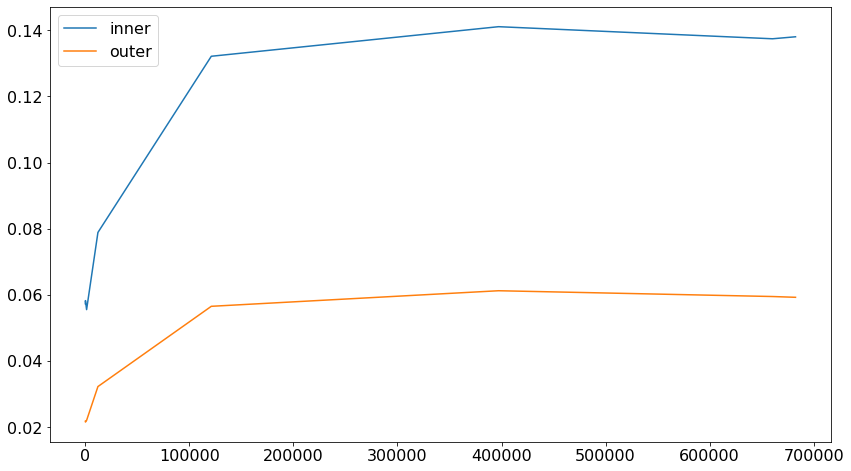

In [45]:
plt.figure(figsize = (14, 8))
plt.plot(sols.t, e_inner_rb, label = 'inner')
plt.plot(sols.t, e_outer_rb, label = 'outer')
plt.legend()

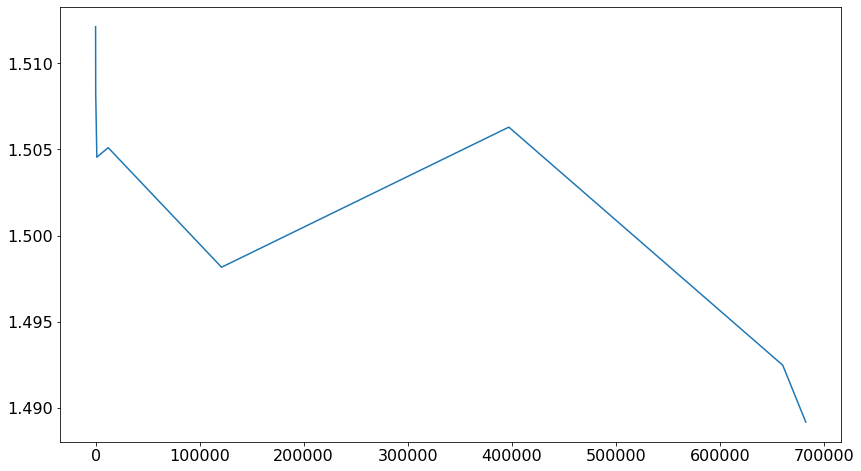

In [46]:
plt.figure(figsize = (14, 8))
plt.plot(sols.t, p_outer_rb/p_inner_rb)

Plotting Hamiltonian EOM:

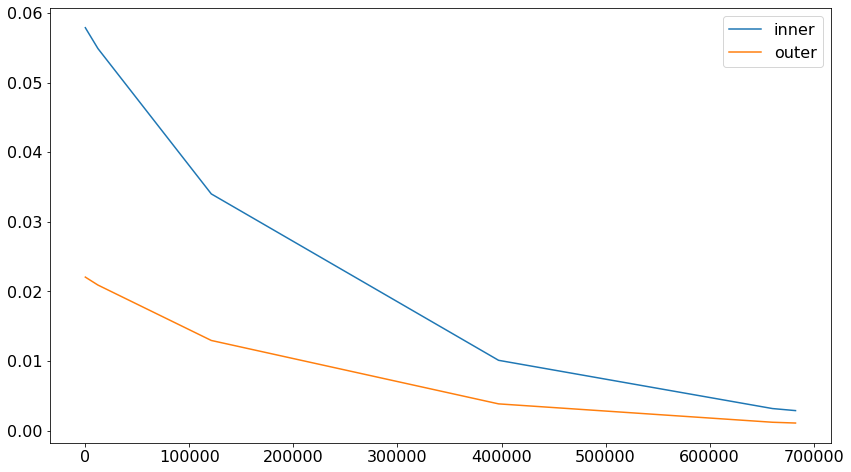

In [47]:
plt.figure(figsize = (14, 8))
plt.plot(sols.t, e_inner_arr, label = 'inner')
plt.plot(sols.t, e_outer_arr, label = 'outer')
plt.legend()

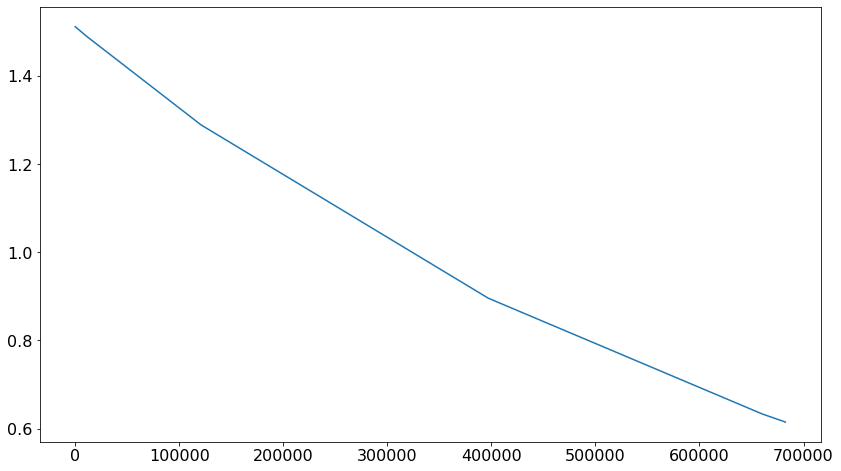

In [48]:
plt.figure(figsize = (14, 8))
plt.plot(sols.t, p_outer_arr/p_inner_arr)

(0.0, 6.283185307179586)

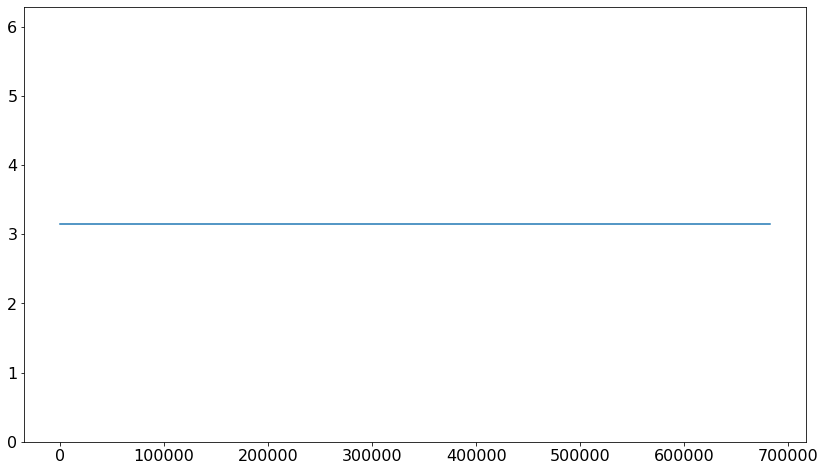

In [49]:
plt.figure(figsize = (14, 8))
plt.plot(sols.t, np.mod(sols.y[1],2*np.pi))
plt.ylim(0,2*np.pi)